In [187]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

np.random.seed(111)
%matplotlib inline
warnings.filterwarnings('ignore')

In [188]:
absent = pd.read_csv('preprocessed_data.csv')
absent.head()

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average day,...,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours,Disease,BMI category,Career level
0,11,26,July,Tuesday,Spring,289,36,13,33,239.554,...,Yes,No,1,90,172,30,4,No,Obese,Mid young adult
1,36,0,July,Tuesday,Spring,118,13,18,50,239.554,...,Yes,No,0,98,178,31,0,No,Obese,Late career professional
2,3,23,July,Wednesday,Spring,179,51,18,38,239.554,...,Yes,No,0,89,170,31,2,No,Obese,Mid career professional
3,7,7,July,Thursday,Spring,279,5,14,39,239.554,...,Yes,Yes,0,68,168,24,4,Yes,Normal Weight,Mid career professional
4,11,23,July,Thursday,Spring,289,36,13,33,239.554,...,Yes,No,1,90,172,30,2,No,Obese,Mid young adult


# Machine Learning Phase

- Dropping Unknown value in the month column

In [189]:
absent = absent[absent['Month of absence'] != 'unknown']

- Dropping ID column

In [190]:
absent.drop('ID', axis=1, inplace=True)

- Scaling ['trestbps', 'age', 'chol', 'thalach'] columns as keeping their values will affect the models performances. 

In [191]:
from sklearn.preprocessing import StandardScaler
df = absent.copy()

cols = ['Transportation expense', 'Age', 'Distance from Residence to Work', 'Height', 'Weight',  'Service time', 'Work load Average day', 'Hit target', 'Body mass index']
for col in cols:
    scaler = StandardScaler()
    df[col] = scaler.fit_transform(df[[col]]).astype(float)
df.select_dtypes('float').head()

,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average day,Hit target,Weight,Height,Body mass index
0,1.011408,0.429556,0.101770,-0.532868,-0.818212,0.638686,0.851673,-0.019046,0.775932
1,-1.544379,-1.121694,1.242825,2.092860,-0.818212,0.638686,1.473056,0.975828,1.009438
2,-0.632665,1.441240,1.242825,0.239405,-0.818212,0.638686,0.774000,-0.350671,1.009438
3,0.861947,-1.661258,0.329981,0.393859,-0.818212,0.638686,-0.857131,-0.682295,-0.625100
4,1.011408,0.429556,0.101770,-0.532868,-0.818212,0.638686,0.851673,-0.019046,0.775932


- Categorical Encoding: By looking at the lenght of all the categorical columns we can do one hot encoding for all of them.
- Encoding the Yes-No column `Social Drinker`, `Social smoker`, `Disciplinary falure`, `Disease`

In [192]:
cols = ['Social smoker', 'Social drinker', 'Disciplinary failure', 'Disease']
for col in cols:
    df[col] = df[col].replace({'Yes': 1, 'No': 0}).astype(int)

In [193]:
for col in df.select_dtypes('object').columns:
    print(f'{col} -->  {len(df[col].unique())}')

for col in df.select_dtypes('object').columns:
    # Perform one-hot encoding
    one_hot_encoded = pd.get_dummies(df[col]).replace({True:1, False:0})

    # Concatenate the one-hot encoded columns with the original DataFrame
    df = pd.concat([df, one_hot_encoded], axis=1)

    df.drop(col, axis=1, inplace=True)

print("the length of the columns of the data after the encoding is ", len(df.columns))

df.columns

Month of absence -->  13
Day of the week -->  5
Seasons -->  4
Education -->  4
BMI category -->  3
Career level -->  5
the length of the columns of the data after the encoding is  51


Index(['Reason for absence', 'Transportation expense',
       'Distance from Residence to Work', 'Service time', 'Age',
       'Work load Average day', 'Hit target', 'Disciplinary failure', 'Son',
       'Social drinker', 'Social smoker', 'Pet', 'Weight', 'Height',
       'Body mass index', 'Absenteeism time in hours', 'Disease', 'April',
       'August', 'December', 'February', 'January', 'July', 'June', 'March',
       'May', 'November', 'October', 'September', 'Unknown', 'Friday',
       'Monday', 'Thursday', 'Tuesday', 'Wednesday', 'Fall', 'Spring',
       'Summer', 'Winter', 'Graduate', 'High School', 'Master/PhD',
       'Postgraduate', 'Normal Weight', 'Obese', 'Overweight',
       'Early young adult', 'Late career professional',
       'Mid career professional', 'Mid young adult', 'Pre-retirement'],
      dtype='object')

- We need to drop one of the weight or the body mass index columns. I will drop the weight column.
- the Service time column has high correlations with age and body mass index columns. so i will drop it.


In [194]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


X = df.drop(['Absenteeism time in hours'], axis=1).select_dtypes('float64')

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                    for i in range(len(X.columns))]

vif_data.sort_values('VIF', ascending=False)

,feature,VIF
6,Weight,154.917153
8,Body mass index,143.668367
7,Height,28.343293
2,Service time,2.541081
3,Age,2.275508
1,Distance from Residence to Work,1.516151
0,Transportation expense,1.347003
4,Work load Average day,1.039202
5,Hit target,1.035654


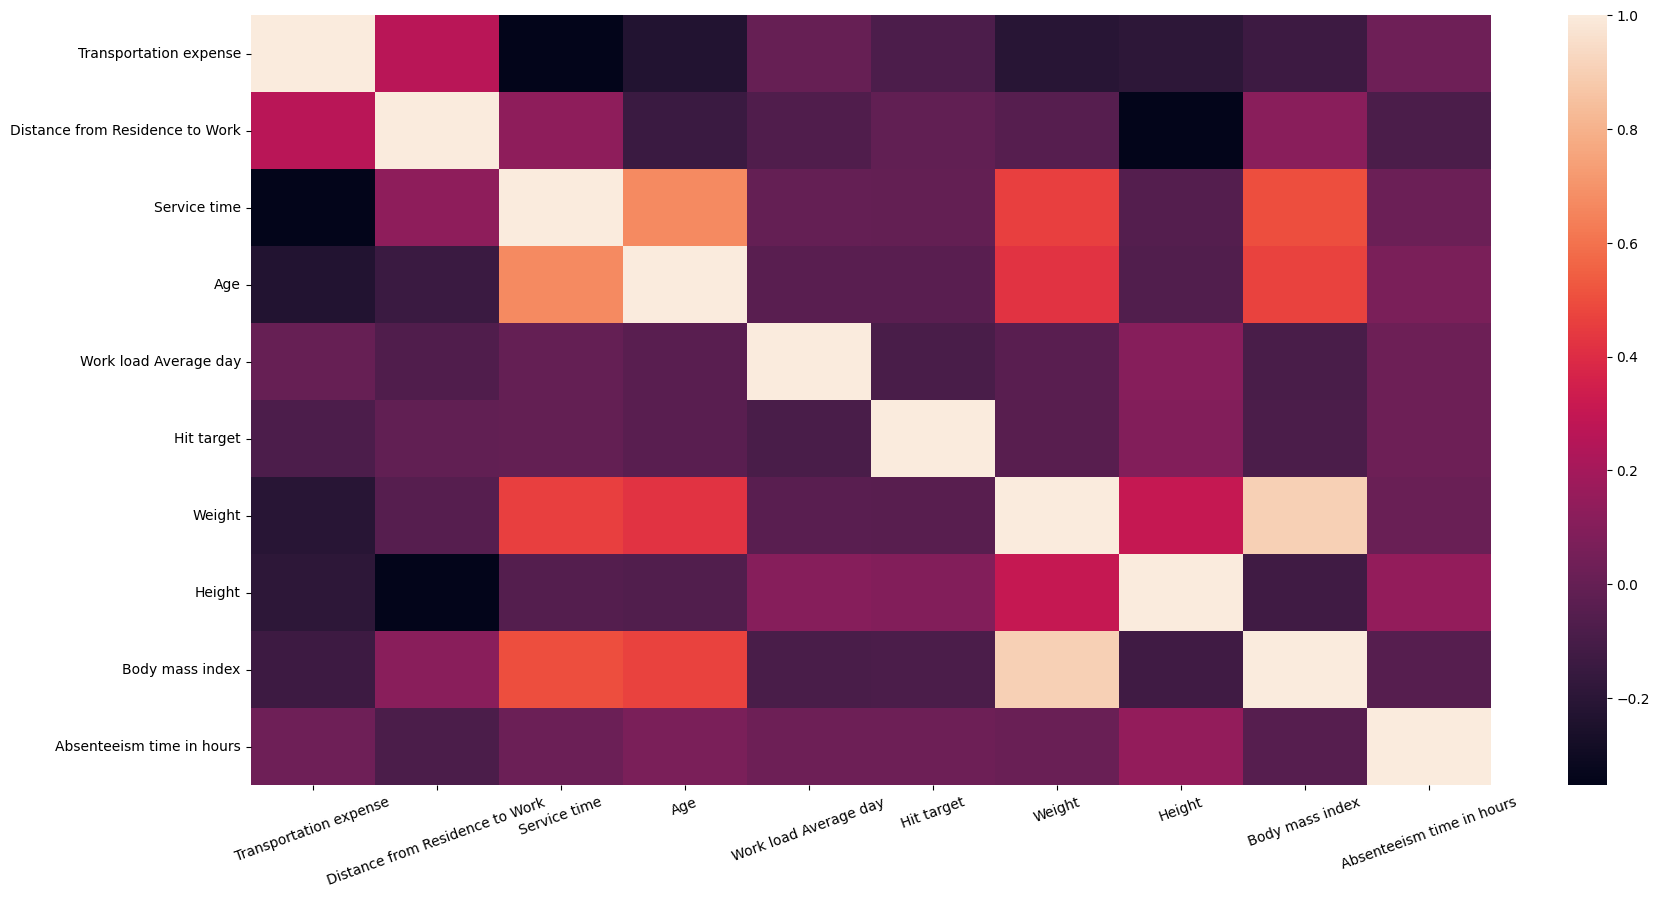

,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average day,Hit target,Weight,Height,Body mass index,Absenteeism time in hours
Transportation expense,1.000000,0.262183,-0.349887,-0.227542,0.005438,-0.080193,-0.207435,-0.194496,-0.136517,0.027585
Distance from Residence to Work,0.262183,1.000000,0.131730,-0.145886,-0.068677,-0.013865,-0.047859,-0.353372,0.113772,-0.088363
Service time,-0.349887,0.131730,1.000000,0.670979,-0.000668,-0.007840,0.455975,-0.053135,0.499718,0.019029
Age,-0.227542,-0.145886,0.670979,1.000000,-0.039425,-0.039224,0.418730,-0.062997,0.470688,0.065760
Work load Average day,0.005438,-0.068677,-0.000668,-0.039425,1.000000,-0.089445,-0.038522,0.103315,-0.090709,0.024749
Hit target,-0.080193,-0.013865,-0.007840,-0.039224,-0.089445,1.000000,-0.044947,0.093267,-0.088939,0.026695
Weight,-0.207435,-0.047859,0.455975,0.418730,-0.038522,-0.044947,1.000000,0.306802,0.904117,0.015789
Height,-0.194496,-0.353372,-0.053135,-0.062997,0.103315,0.093267,0.306802,1.000000,-0.121049,0.144420
Body mass index,-0.136517,0.113772,0.499718,0.470688,-0.090709,-0.088939,0.904117,-0.121049,1.000000,-0.049719
Absenteeism time in hours,0.027585,-0.088363,0.019029,0.065760,0.024749,0.026695,0.015789,0.144420,-0.049719,1.000000


In [195]:
from seaborn import heatmap
df['Absenteeism time in hours'] = df['Absenteeism time in hours'].astype(float)
corr = df.select_dtypes('float').corr()
plt.figure(figsize=(20, 10))
heatmap(corr)
# Rotate x-axis tick labels
plt.xticks(rotation=20)
plt.show()

corr

In [196]:
df.drop(['Service time', 'Weight'], axis=1, inplace=True)

In [197]:
corr['Absenteeism time in hours'].sort_values(key=abs)

Weight                             0.015789
Service time                       0.019029
Work load Average day              0.024749
Hit target                         0.026695
Transportation expense             0.027585
Body mass index                   -0.049719
Age                                0.065760
Distance from Residence to Work   -0.088363
Height                             0.144420
Absenteeism time in hours          1.000000
Name: Absenteeism time in hours, dtype: float64

- There are some Outliers in our columns we will try to detect them Using The IQR method

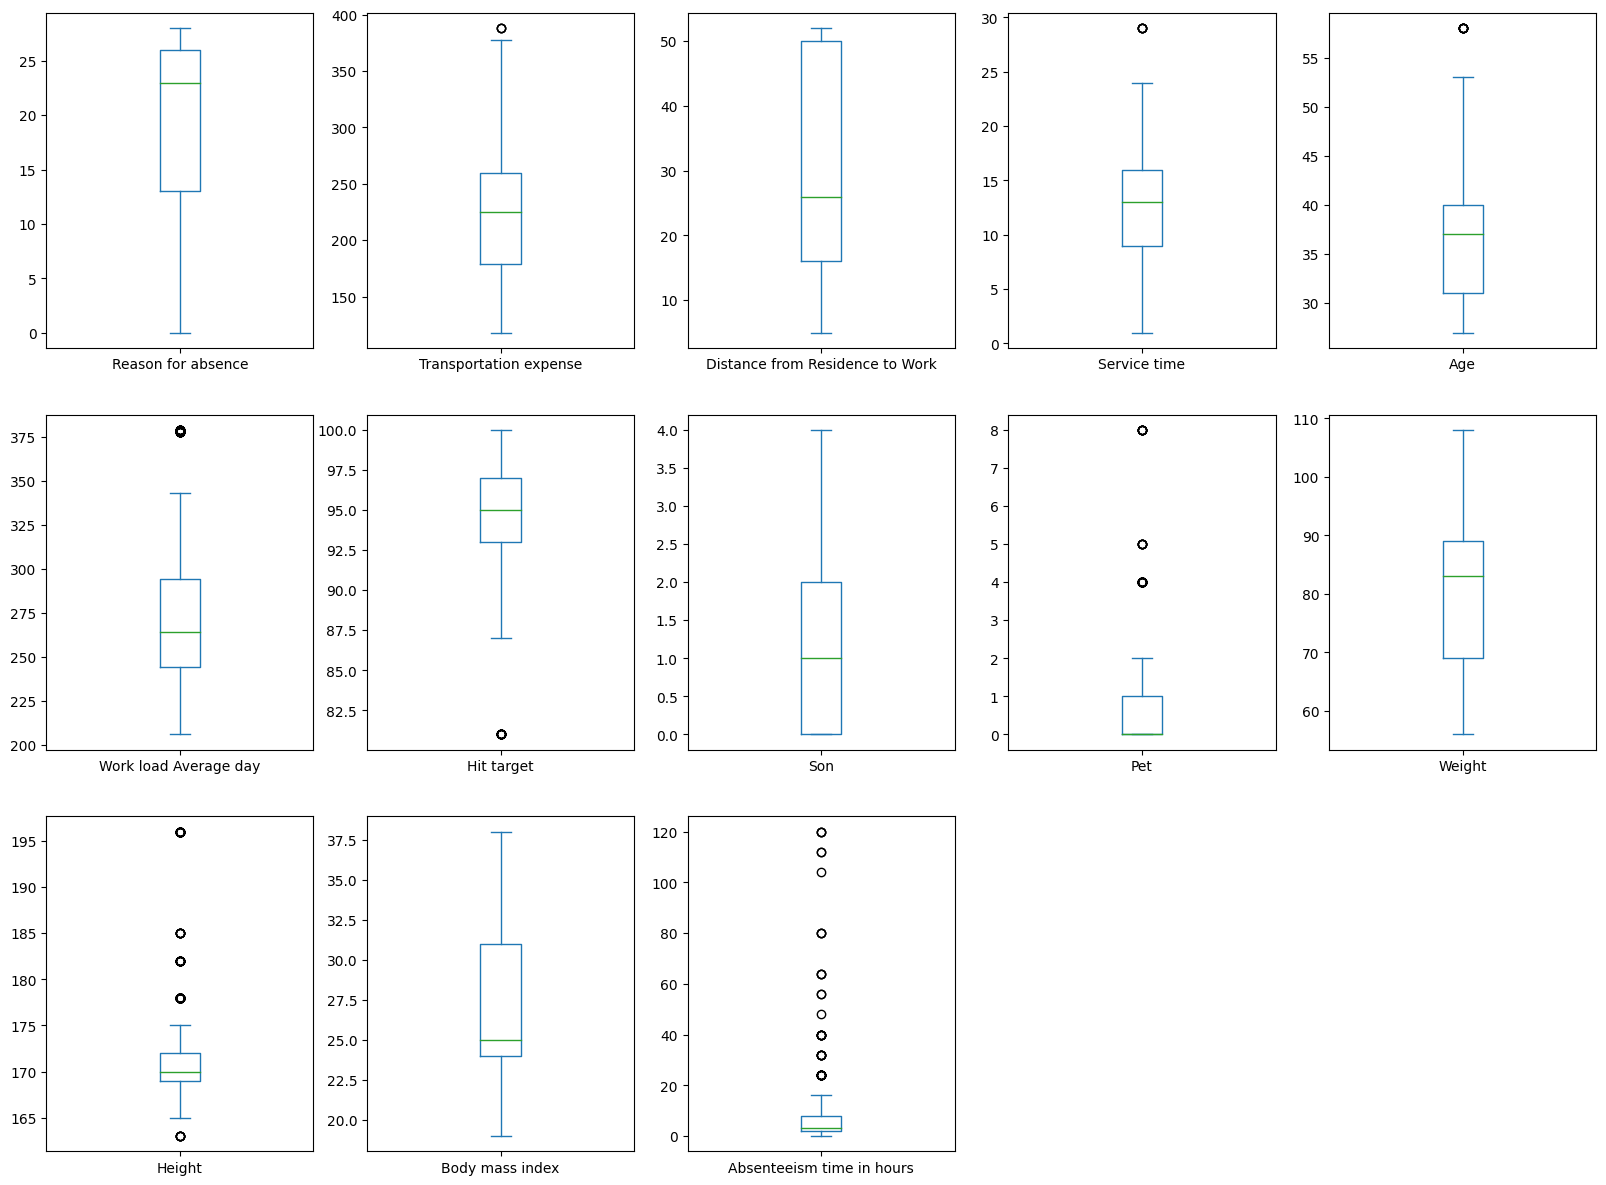

In [198]:
numerical_data = absent.select_dtypes(exclude='object')
numerical_data.plot(kind='box', subplots=True,\
                    sharex=False, sharey=False,\
                    figsize=(20, 20),  layout=(4, 5))

plt.savefig('figs/Box Plots.png', format='png')

- Splitting the data into Features `X` and target `y`

In [199]:
X =  df.drop('Absenteeism time in hours', axis=1)
y = df['Absenteeism time in hours']

- Using the Principle Components Analysis to reduce the number of features. I tried many combinations of n_components [5, 10, 15, 20, 25, 30] and I found that 30 gives the best MSE.

Explained variance ratio of Component 1: 0.8316927098063619
Explained variance ratio of Component 2: 0.029937055704084486
Explained variance ratio of Component 3: 0.022671604650648585
Explained variance ratio of Component 4: 0.01604684711480623
Explained variance ratio of Component 5: 0.01416500792110692
Explained variance ratio of Component 6: 0.013222630370771973
Explained variance ratio of Component 7: 0.011700436885379788
Explained variance ratio of Component 8: 0.010000775296166586
Explained variance ratio of Component 9: 0.006869956218529035
Explained variance ratio of Component 10: 0.005265891246844532
Explained variance ratio of Component 11: 0.0037029022100634468
Explained variance ratio of Component 12: 0.003603781215825124
Explained variance ratio of Component 13: 0.0035178010762766058
Explained variance ratio of Component 14: 0.0026101760146487645
Explained variance ratio of Component 15: 0.0023421260893825998
Explained variance ratio of Component 16: 0.0022831212906249056


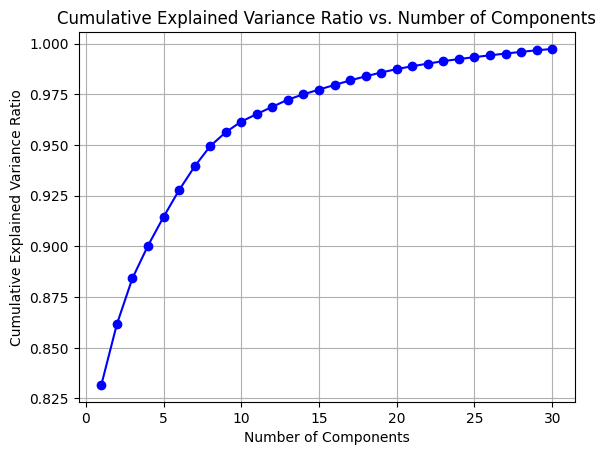

In [200]:
from sklearn.decomposition import PCA

# Apply PCA
pca = PCA(n_components=30)  # Choose the number of components
X_pca = pca.fit_transform(X)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Print the explained variance ratio for each component
for i, ratio in enumerate(explained_variance_ratio):
    print(f"Explained variance ratio of Component {i+1}: {ratio}")

# Transform the original data using the selected number of components
X = pca.transform(X)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs. Number of Components')
plt.grid(True)
plt.show()

### Model Comparison.
- The Multi-Layer Perceptron Classifier  presents the best result so i will go with it. (I commented some models because they represent very bad results.)
    - 4.39  MSE

Knn 5.431 0.401
svr 4.39 0.241
Dtc 7.319 1.069
Rdf 5.653 0.569
grdb 6.391 0.732
Gaus 5.255 0.722
ridge 6.299 0.236
LogR 6.321 0.241
MLP 5.994 0.339


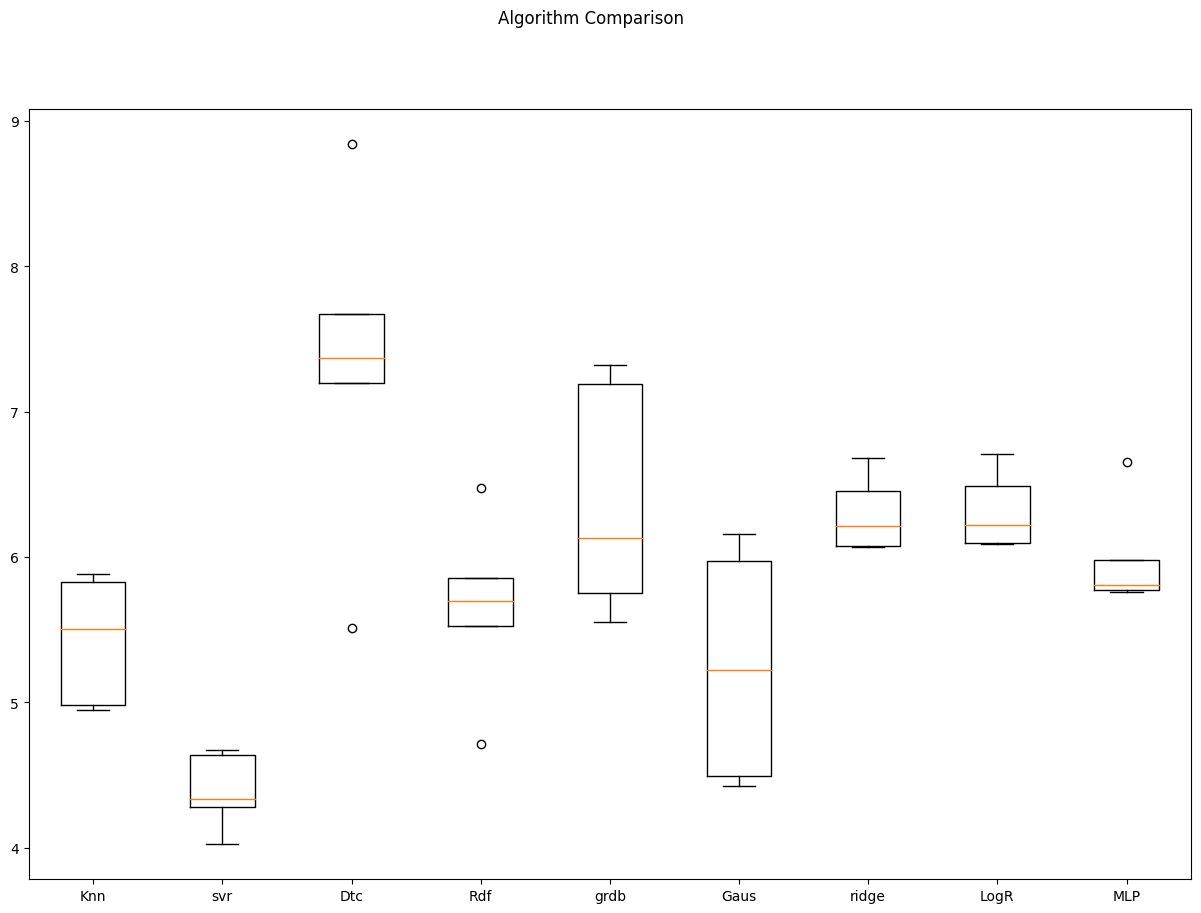

In [201]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold, cross_val_score

models = [
    ('Knn', KNeighborsRegressor()),
    ('svr', SVR()),
    # ('Dtc', DecisionTreeRegressor()),
    ('Rdf', RandomForestRegressor()),
	# ('adb', AdaBoostRegressor()),
    ('grdb', GradientBoostingRegressor()),
    ('Gaus', GaussianNB()),
    # ('LDA', LinearDiscriminantAnalysis()),
    ('ridge', Ridge()),
    ('LogR', LinearRegression()),
    ('MLP', MLPRegressor())
]
# evaluate each model in turn
results = []
names = []
scoring = 'neg_mean_absolute_error'
for name, model in models:
    kfold = KFold(n_splits=5, random_state=0, shuffle=True)
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results.append(-1 * cv_results)
    names.append(name)
    print(name, -1 * np.round(cv_results.mean(), 3), np.round(cv_results.std(), 3))
# boxplot algorithm comparison
fig = plt.figure(figsize=(15, 10))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.savefig('figs/Models Comparison.png',  format='png')
plt.show()

In [202]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model = SVR(**{'C': 100, 'epsilon': 0.1, 'kernel': 'rbf'})

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

- Creating GridSearch to Make Parameters Tuning so we can get better results (MSE: 120 -> 110)

In [203]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Define the parameter grid
param_grid = {
    'svr__kernel': ['linear', 'poly', 'rbf'],
    'svr__C': [0.1, 1, 10, 100],
    'svr__epsilon': [0.1, 0.01, 0.001, 0.0001]
}

# Create an SVR model with feature scaling
svr_model = make_pipeline(StandardScaler(), SVR())

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=svr_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = -grid_search.best_score_

# Print the best parameters and best score
print("Best Parameters:", best_params)
print("Best Score (Negative MSE):", best_score)


Best Parameters: {'svr__C': 100, 'svr__epsilon': 0.1, 'svr__kernel': 'rbf'}
Best Score (Negative MSE): 172.28730347515855


In [204]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming you have the actual target values 'y_true' and predicted target values 'y_pred'
# Calculate mean squared error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate root mean squared error (RMSE)
rmse = mean_squared_error(y_test, y_pred, squared=False)

# Calculate mean absolute error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Calculate R-squared (R²) score
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print("Mean Squared Error (MSE):", round(mse, 2))
print("Root Mean Squared Error (RMSE):", round(rmse, 2))
print("Mean Absolute Error (MAE):", round(mae, 2))
print("R-squared (R²) Score:", round(r2, 2))


Mean Squared Error (MSE): 105.8
Root Mean Squared Error (RMSE): 10.29
Mean Absolute Error (MAE): 4.22
R-squared (R²) Score: 0.14


In [207]:
import pickle
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [208]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
pred = loaded_model.predict(X_test)
result = mean_absolute_error(y_test, pred)
print(result)

4.2237505531473465
